# Unsupervised Learning Capstone Project - Joe Flatt

In [1]:
import numpy as np
import pandas as pd
import scipy

import matplotlib.pyplot as plt
from matplotlib.mlab import PCA as mlabPCA
import seaborn as sns

import re
from collections import Counter

import spacy
import nltk
from nltk.corpus import brown, stopwords

import sklearn
from sklearn import ensemble
from sklearn.svm import SVC
from sklearn import metrics

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import pairwise_distances

from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering

%matplotlib inline

/usr/local/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


# Project Guidelines

First, pick a set of texts. This can be either a series of novels, chapters, or articles. Anything you'd like. It just has to have multiple entries of varying characteristics. At least 100 should be good. There should also be at least 10 different authors, but try to keep the texts related (either all on the same topic of from the same branch of literature - something to make classification a bit more difficult than obviously different subjects).

This capstone can be an extension of your NLP challenge if you wish to use the same corpus. If you found problems with that data set that limited your analysis, however, it may be worth using what you learned to choose a new corpus. Reserve 25% of your corpus as a test set.

The first technique is to create a series of clusters. Try several techniques and pick the one you think best represents your data. Make sure there is a narrative and reasoning around why you have chosen the given clusters. Are authors consistently grouped into the same cluster?

Next, perform some unsupervised feature generation and selection using the techniques covered in this unit and elsewhere in the course. Using those features then build models to attempt to classify your texts by author. Try different permutations of unsupervised and supervised techniques to see which combinations have the best performance.

Lastly return to your holdout group. Does your clustering on those members perform as you'd expect? Have your clusters remained stable or changed dramatically? What about your model? Is it's performance consistent?

If there is a divergence in the relative stability of your model and your clusters, delve into why.

Your end result should be a write up of how clustering and modeling compare for classifying your texts. What are the advantages of each? Why would you want to use one over the other? Approximately 3-5 pages is a good length for your write up, and remember to include visuals to help tell your story!

# Project Overview

My unsupervised capstone project is on the **Brown Corpus**.  "The Brown Corpus was the first million-word electronic corpus of English, created in 1961 at Brown University. This corpus contains text from 500 sources, and the sources have been categorized by genre, such as news, editorial, and so on." - nltk.org.  

The notebook will begin with pre-processing cleaning and sorting on the entire Brown Corpus.  This process will group the information into sentences, tokens (usually individual words and punctuation), documents, and genres.

After the initial pre-processing, I will use the **TF-IDF** method to analyze the words used throughout the Brown Corpus.  The TF-IDF method determines how often a word appears in a document, and assigns that word a weight.  Words that appear often in a lower number of sentences have a higher score.  Words that appear in a lot of sentences have a lower score.

Following TF-IDF, I will use the **LSA** method.  Latent Semantic Analysis is a Singular Value Decomposition (SVD) method that uses PCA on TF_IDF matrix to make clusters of topics.  This method should be helpful to reduce the high dimensionality of the data (all words) and identify may topics with the Brown Corpus since there are a wide variety of topics.

After the TF-IDF & LSA methods are complete, I will use **Logistic Regression** and **Random Forest** machine learning models to see if the genres can be predicted accurately.  Random Forest is often a good model to test with and Logistic Regression is a good model that has some protection against overfitting.  

Finally, I will use **K-Means** and **Agglomerative Clustering** with unsupervised clustering methods to see if clusters of the genres can be seen. K-Means is simple to understand but assumes all points have equaly distant from the cluster center. Agglomerative clusters use a hierarchy of proximity.

# Loading the data

In [2]:
# Utility function for standard text cleaning.
def text_cleaner(text):
    # Visual inspection identifies some form of punctuation spaCy does not recognize
    text = re.sub(r'--',' ',text)
    text = re.sub("/.*? ", " ",text)
    text = re.sub("\\./\\.", "",text)
    text = re.sub("``", "",text)
    text = re.sub("''", "",text)
    text = re.sub("  ", " ",text)
    text = re.sub("./", " ",text)
    text = re.sub("'s", " ",text)
    text = ' '.join(text.split())
    return text


# Load and clean the data.
documents = dict()
corpus = brown.fileids()
genres = [doc[:2] for doc in corpus]
genres = Counter(genres)

for doc in corpus:
    document = brown.raw(doc)
    document = text_cleaner(document)
    documents[doc] = document

Here the words are categorized into sentences, tokens, documents, and genres.  Each document category has a genre related to it, and those are defined below.

In [3]:
# Parse using SpaCy
nlp = spacy.load('en_core_web_sm')

# Define code to genre mapping
genres_codes = {'ca': 'news', 'cb': 'editorial','cc': 'reviews', 'cd': 'religion',
                'ce': 'hobbies', 'cf': 'lore', 'cg': 'belles_lettres', 'ch': 'government',
                'cj': 'learned', 'ck': 'fiction', 'cl': 'mystery', 'cm': 'science_fiction',
                'cn': 'adventure', 'cp': 'romance', 'cr': 'humor'}
# Extract sentences
docs = {}
sentences = []
for key, value in documents.items():
    docs[key] = nlp(value)
    for sentence in docs[key].sents: 
        clean_sent = [token.lemma_.lower() for token in sentence if not token.is_stop and not token.is_punct]
        if len(clean_sent) > 5:
            sentences += [[' '.join(clean_sent), clean_sent, key]]


# Generate processed dataset
sentences = pd.DataFrame(sentences, columns = ['Sentences','Tokens', 'Document'])
sentences.loc[:,'Genre'] = [genres_codes[doc[:2]] for doc in sentences['Document']]

sentences


,Sentences,Tokens,Document,Genre
0,the fulton county grand jury say friday invest...,"[the, fulton, county, grand, jury, say, friday...",ca01,news
1,the jury say term end presentment city executi...,"[the, jury, say, term, end, presentment, city,...",ca01,news
2,only relative handful report receive jury say ...,"[only, relative, handful, report, receive, jur...",ca01,news
3,the jury say find georgia registration electio...,"[the, jury, say, find, georgia, registration, ...",ca01,news
4,-pron- urge city step remedy problem implement...,"[-pron-, urge, city, step, remedy, problem, im...",ca01,news
5,-pron- urge legislature provide enable fund se...,"[-pron-, urge, legislature, provide, enable, f...",ca01,news
6,this major item fulton county general assistan...,"[this, major, item, fulton, county, general, a...",ca01,news
7,the juror say realize proportionate distributi...,"[the, juror, say, realize, proportionate, dist...",ca01,news
8,nevertheless feel future fulton county receive...,"[nevertheless, feel, future, fulton, county, r...",ca01,news
9,the jury comment fulton ordinary court fire pr...,"[the, jury, comment, fulton, ordinary, court, ...",ca01,news


Below are three subsets of the data above and include x and y values:

**Train** to fit the model

**Test** to compared between models and check ovefitting

**Holdout** to make a final unbiased evaluation of the best model

In [4]:
train_test, holdout= train_test_split(sentences, test_size=0.25)
train, test= train_test_split(train_test, test_size=0.30)

print('Train:', train.shape[0])
print('Test:', test.shape[0]) 
print('Holdout:', holdout.shape[0])


Train: 11860
Test: 5084
Holdout: 5649


# TF-IDF

In [5]:
vectorizer = TfidfVectorizer(max_df=0.5, # drop words that occur in more than half the paragraphs
                             min_df=2, # only use words that appear at least twice
                             stop_words='english', 
                             lowercase=True, #convert everything to lower case (since Alice in Wonderland has the HABIT of CAPITALIZING WORDS for EMPHASIS)
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )

# Applying the vectorizer
TfIdf = vectorizer.fit_transform(train['Sentences'])

TfIdf_csr = TfIdf.tocsr()

#A list of dictionaries, one per paragraph
tfidf_bypara = [{} for _ in range(0,TfIdf_csr.shape[0])]

# List of features
terms = vectorizer.get_feature_names()
#for each paragraph, lists the feature words and their tf-idf scores
for i, j in zip(*TfIdf_csr.nonzero()):
    tfidf_bypara[i][terms[j]] = TfIdf_csr[i, j]

#Keep in mind that the log base 2 of 1 is 0, so a tf-idf score of 0 indicates that the word was present once in that sentence.
print('Sentence:\n', sentences['Sentences'][5], 
      '\nTf_idf vector:\n', tfidf_bypara[5])

Sentence:
 -pron- urge legislature provide enable fund set effective date orderly implementation law effect the grand jury take swipe state welfare department handling federal fund grant child welfare service foster home 
Tf_idf vector:
 {'pron': 0.10136656368285323, 'happen': 0.29885824357997953, 'forget': 0.3477410129228685, 'mrs': 0.27157217766868413, 'mathias': 0.4974226957737311, 'away': 0.26605829887308896, 'visit': 0.3145681055877636, 'married': 0.40446935890527713, 'daughter': 0.3535086961345047}


# LSA

The percentage of total variance in the dataset explained by each component from LSA.
 [0.0050203  0.00290273 0.00304028 0.00250174 0.00222126]
Percent variance captured by all components: 20.939987352939767


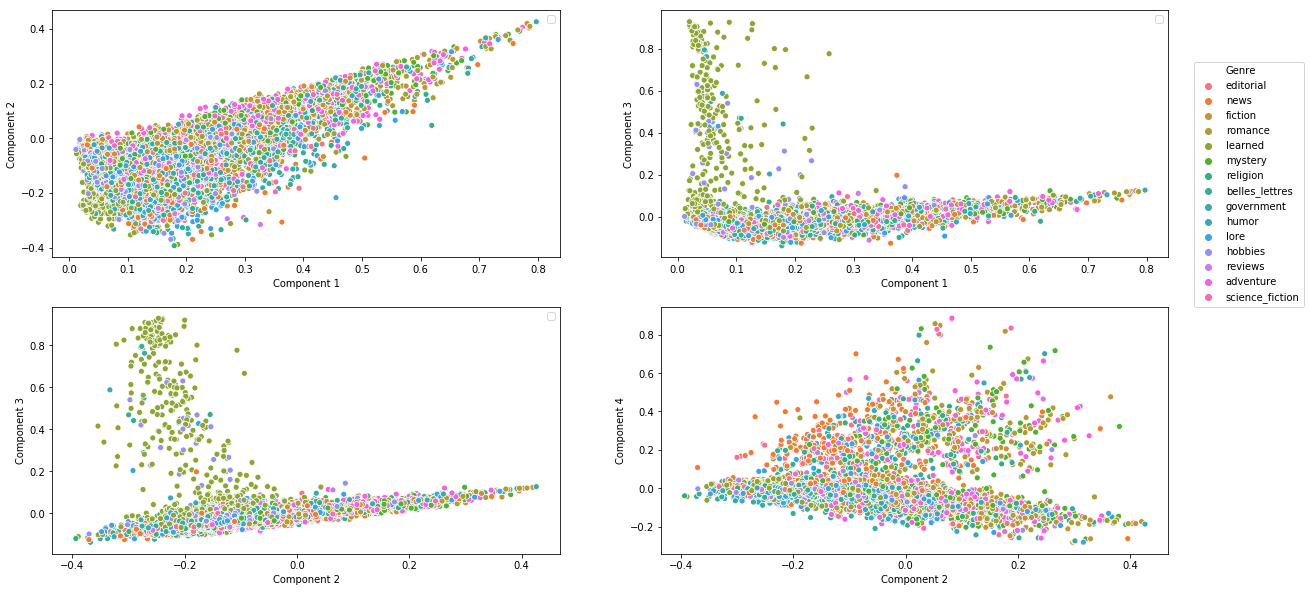

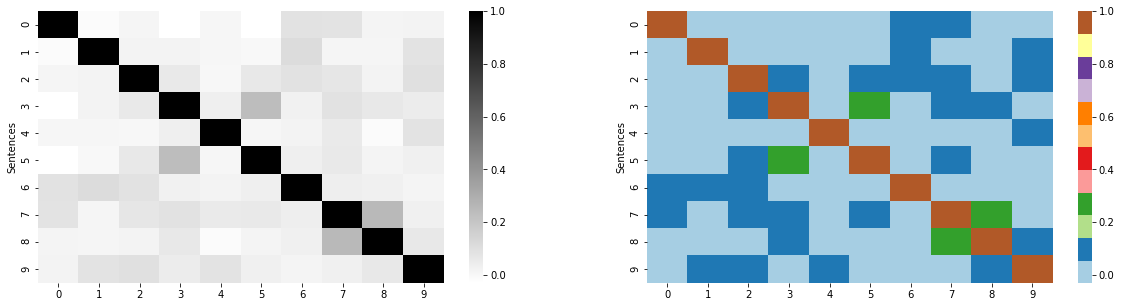

Key:
0 a shock wave africa word dag hammarskjold death african plane crash send shockwave globe as head united nations symbol world peace tragic end come moment peace hang precariously
1 bobby lowe boston hit home gil hodges turn trick brooklyn ebbetts field ed delahanty chuck klein phillies braves joe adcock lou gehrig yankees pat seerey white sox rocky colavito cleveland history road willie big day revive run argument relative merit mays mickey mantle
2 now english painfully silent miss hand -pron- refuse mention notice
3 -pron- hope happen someday say cousin elec good poor cousin elec george say -pron- young theresa
4 some experiment compose repetition independent trial possible outcome the binomial probability distribution describe variation occur set trial binomial experiment -pron- devote chapter binomial distribution mathematical model enormous variety real life phenomenon important property recur probability model -pron- begin example binomial experiment
5 no -pron- forget mrs.

In [6]:
#Our SVD data reducer. Features are reduced down to 250.
svd = TruncatedSVD(250)
lsa = make_pipeline(svd, Normalizer(copy=False))
# Run SVD on the training data, then project the training data.
LSA = lsa.fit_transform(TfIdf)

variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print(
    'The percentage of total variance in the dataset explained by each',
    'component from LSA.\n',
    variance_explained[:5]
)
print("Percent variance captured by all components:",total_variance*100)

# Compare the sklearn solution to ours – a perfect match.

plt.figure(figsize=(20,10))
for i, c in enumerate([(0,1), (0,2), (1,2), (1,3)]): 
    plt.subplot(2,2,i+1)
    sns.scatterplot(x=LSA[:, c[0]], y=LSA[:, c[1]], hue=train['Genre'])
    plt.legend('')
    plt.xlabel('Component ' + str(c[0]+1))
    plt.ylabel('Component ' + str(c[1]+1))
plt.legend(loc = (1.05, 1))
plt.show()



# Compute document similarity using LSA component
similarity = cosine_similarity(LSA)
#Only taking the first 10 sentences
sim_matrix=pd.DataFrame(similarity,index=train['Sentences']).iloc[0:10,0:10]
#Making a plot
plt.figure(figsize=(20,5))
plt.subplot(121)
ax = sns.heatmap(sim_matrix,yticklabels=range(10), cmap='binary')
plt.subplot(122)
ax = sns.heatmap(sim_matrix,yticklabels=range(10), cmap='Paired')
plt.show()

#Generating a key for the plot.
print('Key:')
for i in range(10):
    print(i,sim_matrix.index[i])


## Results

The genres on the LSA plots show scattered results and are not very clustered.  The heatmaps show correlation between sentence similarity.  There is mostly low correlation, with a few examples of slight correlation.

Notice that the 250 features picked from the LSA only capture 20% of the total variability. The trade off of having less features and less overfitting is the loss of a lot of information.

# Logistic Regression

In [7]:
# Transform test set 
test_tfidf = vectorizer.transform(test['Sentences'])
LSA_test = lsa.transform(test_tfidf)

# model vars
x_train = LSA
x_test = LSA_test
y_train = train['Genre']
y_test = test['Genre']

cross-validation:


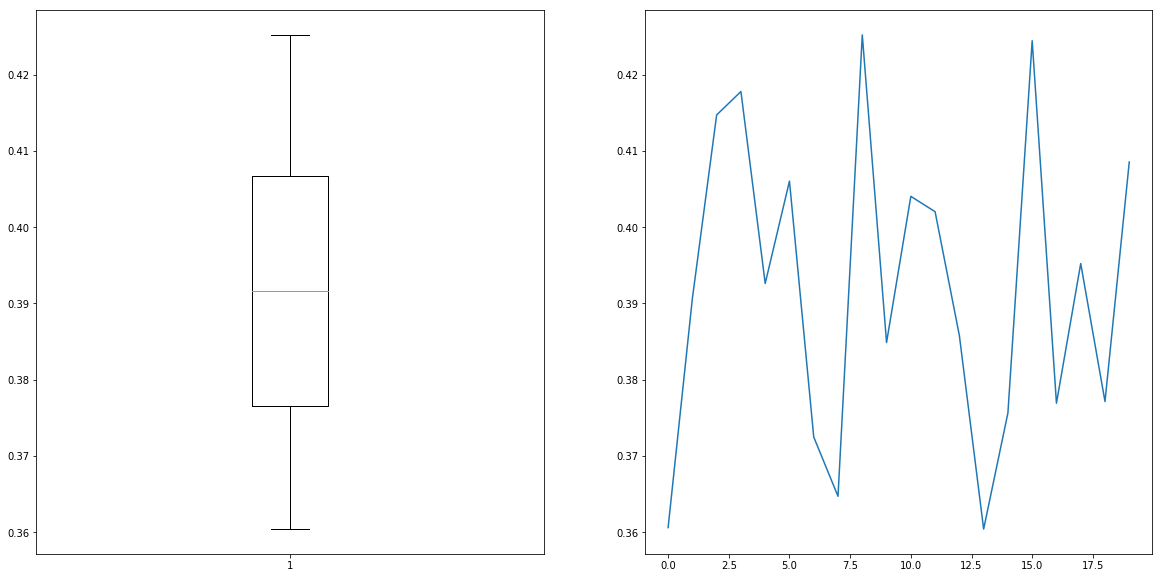

Training set score: 0.44721753794266444
Test set score: 0.39122738001573565


col_0,adventure,belles_lettres,editorial,fiction,government,hobbies,learned,lore,mystery,news,religion,reviews,romance,science_fiction
Genre,,,,,,,,,,,,,,
adventure,153,31,1,41,0,10,9,22,38,11,1,2,52,0
belles_lettres,19,349,10,14,10,23,109,36,24,48,14,8,37,0
editorial,3,71,41,10,13,16,33,24,5,37,8,3,14,0
fiction,70,53,1,64,0,6,13,19,43,12,4,5,65,0
government,0,27,2,0,115,20,52,13,0,19,2,1,0,0
hobbies,14,43,5,14,11,153,67,30,7,14,2,7,14,0
humor,9,27,1,7,0,7,5,6,6,5,2,3,18,0
learned,6,87,6,1,15,35,502,22,5,23,1,3,2,0
lore,34,114,9,12,7,31,63,99,5,37,13,1,15,0


In [8]:
lr = LogisticRegression()
lr.fit(x_train, y_train)

print('cross-validation:')
cx_val = cross_val_score(lr, x_train, y_train, cv=20)
plt.figure(figsize=(20,10))
plt.subplot(121)
plt.boxplot(cx_val)
plt.subplot(122)
plt.plot(cx_val)
plt.show()
print('Training set score:', lr.score(x_train, y_train))
print('Test set score:', lr.score(x_test, y_test))
pd.crosstab(y_test, lr.predict(x_test))

# Random Forest

cross-validation:


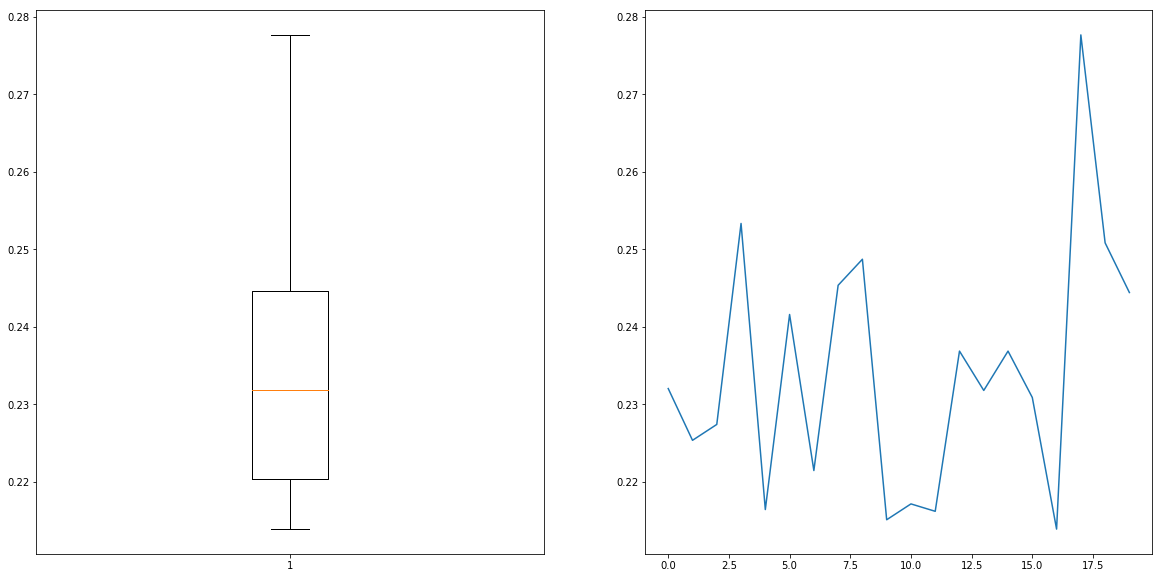

Training set score: 0.9946037099494098
Test set score: 0.23819826907946498


col_0,adventure,belles_lettres,editorial,fiction,government,hobbies,humor,learned,lore,mystery,news,religion,reviews,romance,science_fiction
Genre,,,,,,,,,,,,,,,
adventure,127,61,8,60,2,12,3,15,20,33,2,0,1,26,1
belles_lettres,78,275,25,44,28,17,2,94,41,24,33,8,6,25,1
editorial,20,83,22,13,24,16,2,35,23,6,25,1,2,6,0
fiction,83,90,6,42,0,12,5,15,20,36,7,1,1,36,1
government,3,45,12,7,102,9,1,41,8,3,14,1,2,3,0
hobbies,23,101,11,22,16,67,4,67,31,10,14,1,2,11,1
humor,16,23,3,12,3,0,2,9,11,7,2,0,2,6,0
learned,27,134,17,16,30,41,1,379,25,7,15,3,5,8,0
lore,51,130,23,36,16,35,1,53,39,15,20,7,4,10,0


In [9]:
rfc = ensemble.RandomForestClassifier()
rfc.fit(x_train, y_train)

print('cross-validation:')
cx_val = cross_val_score(rfc, x_train, y_train, cv=20)
plt.figure(figsize=(20,10))
plt.subplot(121)
plt.boxplot(cx_val)
plt.subplot(122)
plt.plot(cx_val)
plt.show()
print('Training set score:', rfc.score(x_train, y_train))
print('Test set score:', rfc.score(x_test, y_test))
pd.crosstab(y_test, rfc.predict(x_test))

## Results

Both Logistic Regression and Random Forest Models had overfitting.  Random Forest performed better on the train set; however, it was extremely overfitting.  Logistic Regression performed better on the test set and had much less overfitting, so that is the model I will use on the holdout group later. 

# Clusters

## K-Means

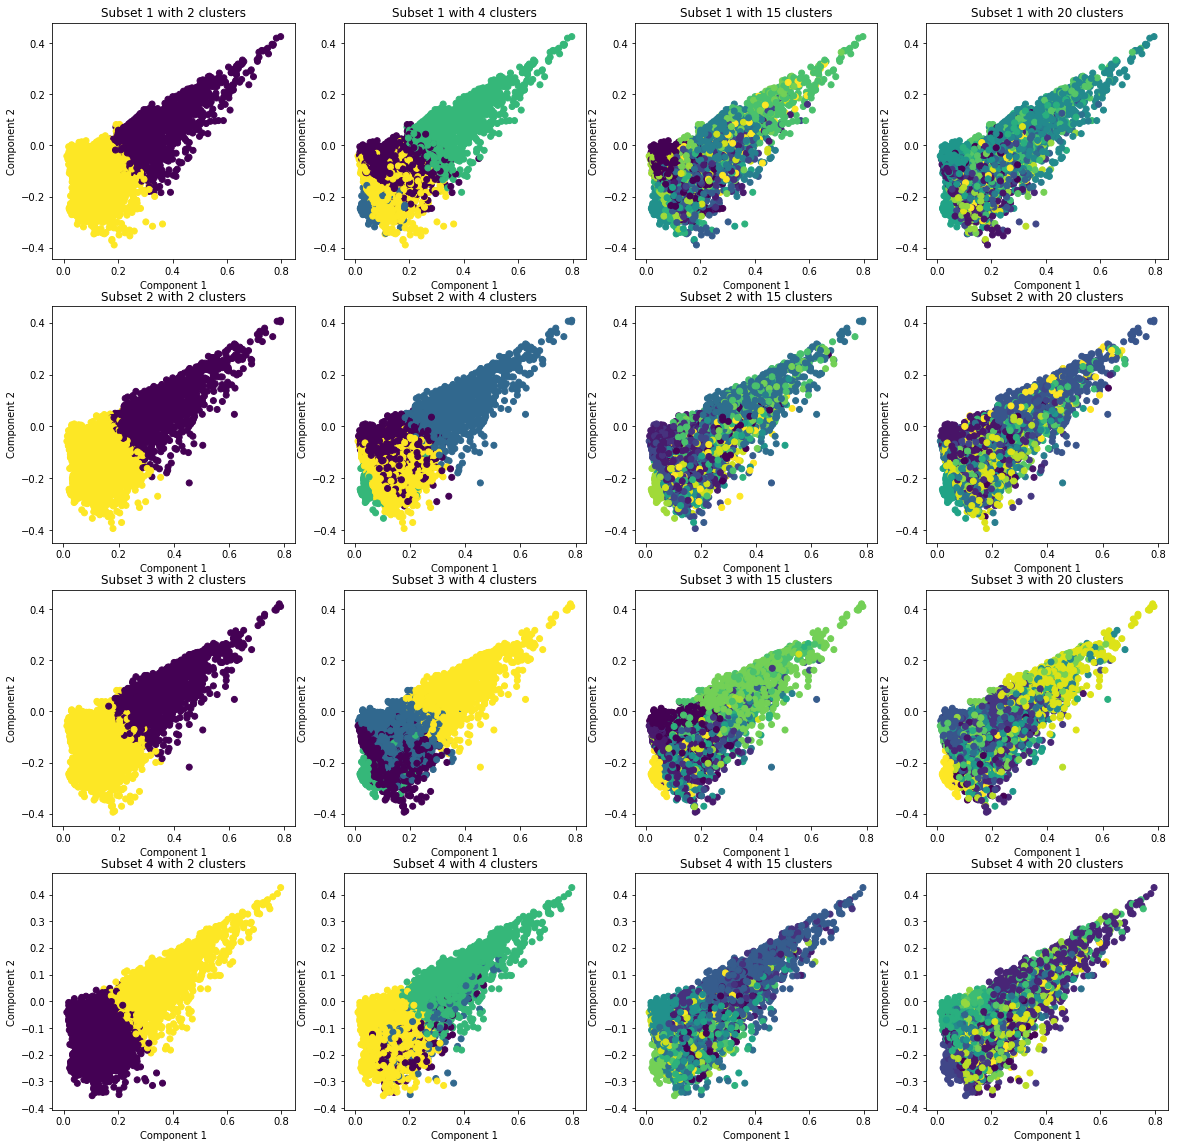

In [10]:
# Split the data to test for consistent clustering
lsa1, lsa3= train_test_split(LSA, test_size=0.50)
lsa1, lsa2= train_test_split(LSA, test_size=0.50)
lsa3, lsa4= train_test_split(LSA, test_size=0.50)

plt.figure(figsize=(20,20))
# Calculate predicted values.
preds = {}
models = {}
clusters = (2,4,len(genres), 20)

for row, data in enumerate([lsa1, lsa2, lsa3, lsa4, LSA]):
    
    # Generate cluster predictions and store them for clusters 2 to 4.
    for col, nclust in  enumerate(clusters):
        models[row, nclust] = KMeans(n_clusters=nclust, random_state=42).fit(data)
        preds[row, nclust] = models[row, nclust].predict(data)
        
        if row != 4:
            plt.subplot(4, 4, row*4 + (col+1))
            plt.scatter(data[:, 0], data[:, 1], c=preds[row, nclust])
            plt.title('Subset ' + str(row + 1) +' with ' + str(nclust) +' clusters')
            plt.xlabel('Component 1')
            plt.ylabel('Component 2')
        
plt.show()

In [11]:
# Function to evaluate the clustering
def cluster_eval(clusters, preds, models, n):
    for i in clusters: 
        pred = preds[4,i]
        model = models[4,i]
        labels = model.labels_
        print('Adjusted Rand index for', i, 'clusters:', round(metrics.adjusted_rand_score(train['Genre'], pred),5))
        print('The silhouette coefficient for %d clusters: %.4f \n' % (i, metrics.silhouette_score(LSA, labels, metric='euclidean')))

    return(pd.crosstab(train['Genre'], preds[4,n]).T)

cluster_eval(clusters, preds, models, 15)

Adjusted Rand index for 2 clusters: 0.02646
The silhouette coefficient for 2 clusters: 0.0146 

Adjusted Rand index for 4 clusters: 0.03356
The silhouette coefficient for 4 clusters: 0.0103 

Adjusted Rand index for 15 clusters: 0.04847
The silhouette coefficient for 15 clusters: 0.0267 

Adjusted Rand index for 20 clusters: 0.044
The silhouette coefficient for 20 clusters: 0.0312 



Genre,adventure,belles_lettres,editorial,fiction,government,hobbies,humor,learned,lore,mystery,news,religion,reviews,romance,science_fiction
col_0,,,,,,,,,,,,,,,
0,45,64,14,59,2,23,9,31,28,47,12,4,14,67,5
1,36,57,20,47,5,10,9,18,26,50,8,14,7,46,13
2,8,64,35,15,23,49,5,24,41,9,52,30,29,13,2
3,11,48,36,12,80,37,12,36,41,13,84,12,17,9,5
4,9,335,115,17,242,235,15,868,202,13,138,96,59,14,13
5,51,70,25,50,14,15,19,26,36,51,36,12,25,37,4
6,9,19,24,8,2,12,4,44,37,2,42,1,0,8,0
7,4,98,68,6,62,19,2,37,49,3,49,32,17,10,5
8,53,19,7,31,1,10,6,37,17,29,12,5,9,29,6


## Agglomerative clustering

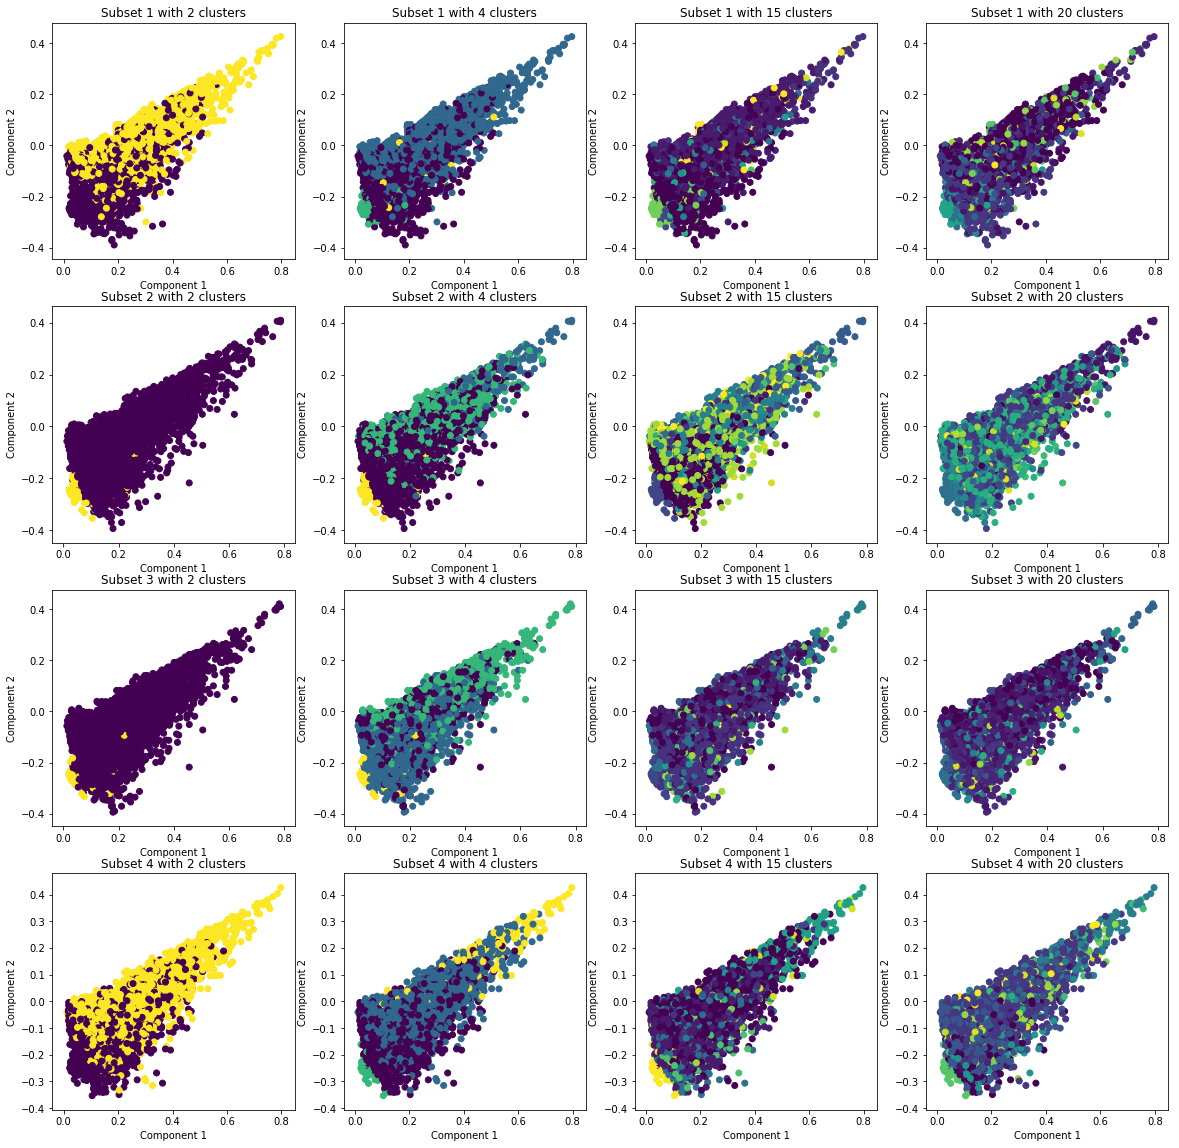

In [12]:
plt.figure(figsize=(20,20))

# Calculate predicted values.
preds_2 = {}
models_2 = {}

for row, data in enumerate([lsa1, lsa2, lsa3, lsa4, LSA]):
    
    # Generate cluster predictions and store them for clusters 2 to 4.
    for col, nclust in  enumerate(clusters):
        models_2[row, nclust] = AgglomerativeClustering(n_clusters=nclust).fit(data)
        preds_2[row, nclust] = AgglomerativeClustering(n_clusters=nclust).fit_predict(data)
        
        if row != 4:
            plt.subplot(4, 4, row*4 + (col+1))
            plt.scatter(data[:, 0], data[:, 1], c=preds_2[row, nclust])
            plt.title('Subset ' + str(row + 1) +' with ' + str(nclust) +' clusters')
            plt.xlabel('Component 1')
            plt.ylabel('Component 2')
        
plt.show()

In [13]:
cluster_eval(clusters, preds_2, models_2, 20)

Adjusted Rand index for 2 clusters: 0.02105
The silhouette coefficient for 2 clusters: 0.0071 

Adjusted Rand index for 4 clusters: 0.01734
The silhouette coefficient for 4 clusters: -0.0062 

Adjusted Rand index for 15 clusters: 0.02967
The silhouette coefficient for 15 clusters: -0.0108 

Adjusted Rand index for 20 clusters: 0.02194
The silhouette coefficient for 20 clusters: -0.0139 



Genre,adventure,belles_lettres,editorial,fiction,government,hobbies,humor,learned,lore,mystery,news,religion,reviews,romance,science_fiction
col_0,,,,,,,,,,,,,,,
0,279,472,165,267,140,292,83,391,321,271,259,83,138,289,56
1,39,34,8,31,1,5,9,11,20,45,11,4,5,47,10
2,3,15,10,32,1,2,2,6,13,3,10,54,0,9,2
3,21,9,3,14,2,24,0,22,22,11,6,0,5,12,0
4,375,311,90,298,24,89,78,101,189,289,129,54,83,328,49
5,3,7,0,3,6,4,0,133,1,0,0,0,1,1,0
6,24,7,6,37,0,6,5,3,5,29,9,1,0,20,1
7,62,488,190,92,178,238,30,519,310,60,242,129,102,80,23
8,23,62,33,16,54,145,13,366,33,17,43,29,17,15,5


## Results

K-Means with 15 & 20 clusters appears to have the best results according to the Adjusted Rand Index.  The Adjusted Rand Index, however, shows that our clustering solutions were close to random.  Let's see how the holdout group performs.

# Logistic Regression On Holdout Group

In [14]:
holdout_tfidf = vectorizer.transform(holdout['Sentences'])
LSA_holdout = lsa.transform(holdout_tfidf)

# model vars
x_holdout = LSA_holdout
y_holdout = holdout['Genre']

print('Holdout set score:', lr.score(x_holdout, y_holdout))
print('Test set score from earlier:', lr.score(x_test, y_test))
pd.crosstab(y_holdout, lr.predict(x_holdout))

Holdout set score: 0.3915737298636927
Test set score from earlier: 0.39122738001573565


col_0,adventure,belles_lettres,editorial,fiction,government,hobbies,humor,learned,lore,mystery,news,religion,reviews,romance,science_fiction
Genre,,,,,,,,,,,,,,,
adventure,174,47,2,46,1,11,0,11,12,45,6,1,0,70,0
belles_lettres,33,422,8,20,10,17,0,114,39,20,40,8,7,59,0
editorial,10,75,35,8,19,18,0,27,22,8,46,6,4,20,0
fiction,73,67,1,70,0,17,1,13,25,39,16,4,3,69,0
government,0,24,5,1,145,25,0,65,11,2,24,1,1,1,0
hobbies,16,29,8,9,11,179,0,74,21,6,16,0,10,8,0
humor,7,34,0,7,0,5,1,9,9,8,8,1,1,24,0
learned,11,113,8,2,32,28,0,542,17,5,25,4,3,5,0
lore,27,119,10,13,9,31,1,91,97,10,40,9,1,18,1


Logistic Regression performed about the same on the holdout group vs the test set score from earlier.  Performing an original test and then verifing the accuracy of the model on the *new* data (holdout) verifies that the model is working properly. 

The genres the model predicted the best was **goverment** (145 correct, 108 incorrect = 57% correct), **learned** (52%), and **religion** (52%).

# K-means On Holdout Group

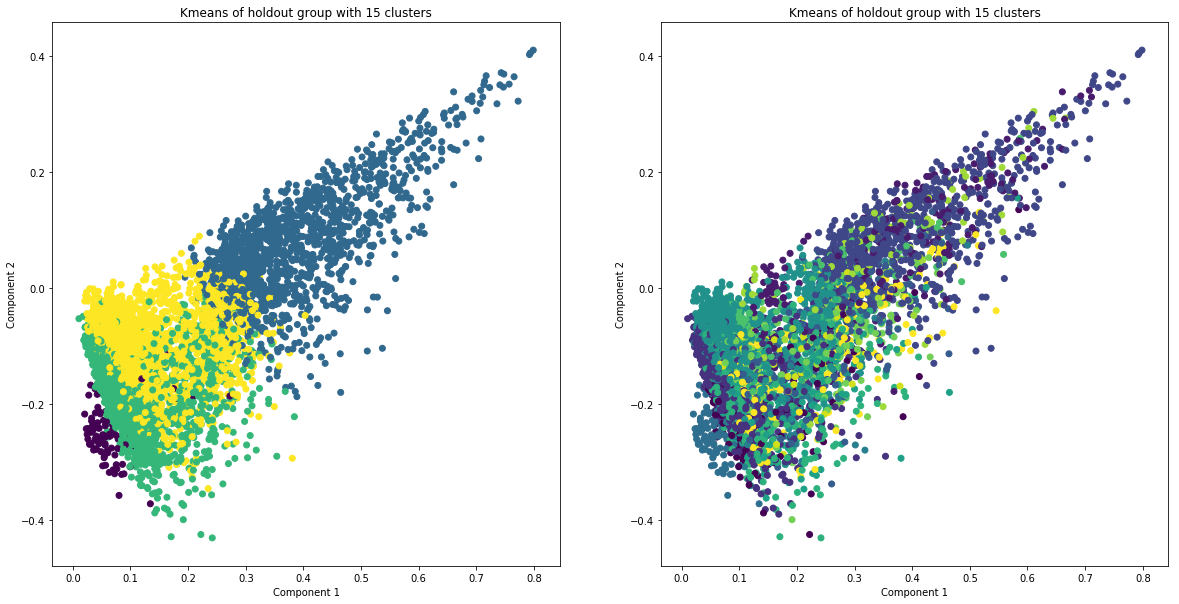

In [15]:
plt.figure(figsize=(20,10))

plt.subplot(121)
preds = KMeans(n_clusters=4, random_state=42).fit_predict(LSA_holdout)
plt.scatter(LSA_holdout[:, 0], LSA_holdout[:, 1], c=preds)
plt.title('Kmeans of holdout group with 15 clusters')
plt.xlabel('Component 1')
plt.ylabel('Component 2')

plt.subplot(122)
preds = KMeans(n_clusters=15, random_state=42).fit_predict(LSA_holdout)
plt.scatter(LSA_holdout[:, 0], LSA_holdout[:, 1], c=preds)
plt.title('Kmeans of holdout group with 15 clusters')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
        
plt.show()

In [16]:
pd.crosstab(holdout['Genre'], preds).T

Genre,adventure,belles_lettres,editorial,fiction,government,hobbies,humor,learned,lore,mystery,news,religion,reviews,romance,science_fiction
col_0,,,,,,,,,,,,,,,
0,0,14,15,3,34,5,0,31,14,1,21,4,4,1,0
1,33,32,7,23,2,3,14,1,16,24,49,4,4,58,5
2,2,123,26,4,105,101,4,385,72,2,38,27,27,4,5
3,126,116,24,119,7,21,25,37,40,122,25,24,14,125,21
4,48,41,11,28,7,7,6,13,19,19,11,17,5,14,5
5,0,0,0,0,6,9,0,79,1,0,0,0,0,0,0
6,0,6,17,1,30,1,0,6,7,0,12,3,1,1,0
7,117,167,71,131,28,130,31,97,131,112,128,34,56,128,22
8,5,31,20,9,25,17,3,20,20,5,32,8,5,3,7


Cluster 2 is highly correlated with the "learned" genre; however, the results are pretty scattered otherwise.  The results were pretty scattered earlier as well.

# Conclusion

Since the Brown Corpus contains a wide variety of texts, it is difficult to build models that predict with high accuracy.  Logistic Regression and K-Means performed similarly on the original test set and on the holdout group.  The models are stable; however, accuracy could definitely be improved.  Unfortunately there were too many topics with too few sentences and not enough information to clearly distinguish the genres.

**Ways to Improve:**

1) Topics were too similar to distinguish: sentences may be very general and similar between genres. Using paragraphs instead of sentences could make the features more complex and unique.

2) You could include other features that are informative (for example size of sentences in addition to LSA).

3) Using the entire Brown Corpus instead of a sample of the Corpus helped results, so more text data should improve the models.

Other methods used in prior versions of this notebook included Search Vector Classfication, Gradient Boosting, and Spectral Clustering.  Search Vector Classification performed poorly, Gradient Boosting's processing time was difficult to work with, and Spectral Clustering required too much memory.

**Final Results:**

**Logistic Regression** predicted the **goverment**, **learned**, and **religion** genres the best.  

**K-Means** was pretty scattered on both the test and holdout groups.